In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Coordinates in (row, column) format
INITIAL_STATE = [3, 0]
FINAL_STATE = [3, 11]

WIDTH = 12
HEIGHT = 4
ACTION_COUNT = 4

MAX_X = WIDTH - 1
MAX_Y = HEIGHT - 1

In [3]:
class CliffWalk:
    up_draft = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:1, 9:0}
    pos = []
    
    def __init__(self):        
        self.reset()
        
    
    def step(self, action):
        """
        Takes the given action and returns a tuple (next_state, reward, done)
        """
        reward = 0
        done = self.is_final()
        
        if not done:   
            # Normally, reward is -1
            reward = -1
            new_pos = np.copy(self.pos)
            
            if action == LEFT:
                new_pos[1] -= 1
            elif action == UP:
                new_pos[0] -= 1
            elif action == RIGHT:
                new_pos[1] += 1
            elif action == DOWN:
                new_pos[0] += 1                     
            
            # If final position is valid, move to new location
            if not (new_pos[0] < 0 or new_pos[0] > MAX_Y or new_pos[1] < 0 or new_pos[1] > MAX_X):
                if self.is_cliff(new_pos):
                    reward = -100
                    self.pos = np.copy(INITIAL_STATE)
                else:
                    self.pos = new_pos                
        
        return np.copy(self.pos), reward, self.is_final()
    
    def is_cliff(self, pos):
        return (pos[0] == 3) and (1 <= pos[1] <= 10)
    
    def reset(self):
        self.pos = np.copy(INITIAL_STATE)
        return np.copy(self.pos)
        
    def is_final(self):
        return self.pos[0] == FINAL_STATE[0] and self.pos[1] == FINAL_STATE[1]    

In [4]:
def epoch_greedy(Q, state):
    qa = Q[state[0], state[1]]
    prob = np.random.rand(1)
    if prob > epsilon:
        # exploit (greedy)
        action_index = np.random.choice(np.flatnonzero(qa == qa.max()))
    else:
        # explore (random action)
        action_index = np.random.randint(0, ACTION_COUNT)
    
    return action_index

In [5]:
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

In [6]:
# Sarsa learning
gamma = 1 # no discount
epsilon = 0.1
alpha = 0.5
Q = np.zeros((HEIGHT, WIDTH, ACTION_COUNT))
episodes = 500

env = CliffWalk()
rewards = 0
episode = 0
s = env.reset()
y_sarsa = [] # For plotting

while episode < episodes:    
    # Select action using policy derived from Q (e-greedy)
    a = epoch_greedy(Q, s)
        
    # Take action and observe next state and reward
    s_, r, done = env.step(a)
    
    # Choose A' from S' using policy derived from Q (e-greedy)
    a_ = epoch_greedy(Q, s_)
    
    # Update
    if done:
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r - Q[s[0], s[1], a])
    else:
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r + gamma * Q[s_[0], s_[1], a_] - Q[s[0], s[1], a])
    
    s = s_
    rewards += r
    
    # Episode over, reset environment
    if done:                
        episode += 1
        y_sarsa.append(rewards)
        
        s = env.reset()
        rewards = 0

In [7]:
# Q-learning
gamma = 1
epsilon = 0.1
alpha = 0.5
Q = np.zeros((HEIGHT, WIDTH, ACTION_COUNT))
episodes = 500

env = CliffWalk()
rewards = 0
episode = 0
s = env.reset()
y_ql = [] # For plotting

while episode < episodes:    
    # Select action using policy derived from Q (e-greedy)
    a = epoch_greedy(Q, s)
        
    # Take action and observe next state and reward
    s_, r, done = env.step(a)
    
    # Choose A' from S' using policy derived from Q (e-greedy)
    a_ = epoch_greedy(Q, s_)
    
    # Update
    if done:
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r - Q[s[0], s[1], a])
    else:
        max_qa = np.amax(Q[s_[0], s_[1]])
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r + gamma * max_qa - Q[s[0], s[1], a])
    
    s = s_
    rewards += r
    
    # Episode over, reset environment
    if done:                
        episode += 1
        y_ql.append(rewards)
        
        s = env.reset()
        rewards = 0

In [8]:
sarsa_average = moving_average(y_sarsa, w=30)
ql_average = moving_average(y_ql, w=30)


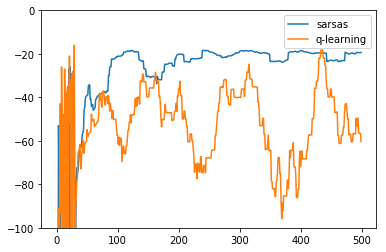

In [9]:
x = range(episodes)
plt.ylim([-100, 0])
plt.plot(x, sarsa_average, label='sarsas')
plt.plot(x, ql_average, label='q-learning')
plt.legend()
plt.show()